In [1]:
import cv2
import numpy as np
from pdf2image import convert_from_path
from IPython.display import display, Image
import matplotlib.pyplot as plt

In [ ]:
pdf_path = "src/algebra_graph/part5_ideals.pdf"  # Replace with your PDF file path
images = convert_from_path(pdf_path)
if not images:
    raise ValueError(f"No pages found in {pdf_path}")

In [3]:
def process_contours(contours, vertical_gap_threshold=20):
    # First pass: Combine contours with small vertical gaps
    combined_contours = []
    prev_contour = None
    
    # Sort contours by y-position (top to bottom)
    sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])
    
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        current_rect = (x, y, w, h)
        
        if prev_contour is None:
            prev_contour = current_rect
            combined_contours.append(contour)
            continue
            
        px, py, pw, ph = prev_contour
        # Check vertical gap between current and previous contour
        vertical_gap = y - (py + ph)
        
        if vertical_gap < vertical_gap_threshold:
            # Combine with previous contour
            new_x = min(px, x)
            new_y = min(py, y)
            new_w = max(px + pw, x + w) - new_x
            new_h = max(py + ph, y + h) - new_y
            prev_contour = (new_x, new_y, new_w, new_h)
            # Replace last contour with combined version
            combined_contours[-1] = np.array([[new_x, new_y], 
                                            [new_x + new_w, new_y],
                                            [new_x + new_w, new_y + new_h],
                                            [new_x, new_y + new_h]])
        else:
            prev_contour = current_rect
            combined_contours.append(contour)
    
    # Second pass: Remove contours contained within larger contours
    final_contours = []
    bounding_rects = [cv2.boundingRect(c) for c in combined_contours]
    
    for i, (x1, y1, w1, h1) in enumerate(bounding_rects):
        is_inside = False
        for j, (x2, y2, w2, h2) in enumerate(bounding_rects):
            if i == j:
                continue
            # Check if contour i is completely inside contour j
            if (x1 >= x2 and y1 >= y2 and 
                x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2):
                is_inside = True
                break
                
        if not is_inside:
            final_contours.append(combined_contours[i])
    
    return final_contours

In [4]:
def find_large_contours(image, left_region_ratio=0.25):
    bottom_crop = 0.10

    image_arr = np.array(image)[:int((1 - bottom_crop) * image.height)]
    height, width = image_arr.shape[:2]

    left_width = int(width * left_region_ratio)
    left_region = image_arr[:, :left_width]
    # blurred_left = cv2.erode(left_region, (15, 15), iterations=1)
    blurred_left = cv2.stackBlur(left_region, (21, 21))

    gray_blurred = cv2.cvtColor(blurred_left, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_blurred, 250, 255, cv2.THRESH_BINARY_INV) # 250 to filter white vs. non-white pixels
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours  = process_contours(contours, vertical_gap_threshold=40)

    large_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 100:  # Filter small noise
            large_contours.append((y, h))

    return large_contours

In [5]:
def find_optimal_vertical_line(boxes, large_contours, edge_margin=50):
    if not boxes:
        return None

    # Avoid edges (candidate x must be within box bounds ± margin)
    min_x = min(box[0] for box in boxes) + edge_margin
    max_x = max(box[0] + box[2] for box in boxes) - edge_margin

    if min_x >= max_x:
        return None  # No valid region

    # Generate candidate x-coordinates (every 1 pixel for precision)
    candidate_xs = np.arange(min_x, max_x, 1)
    best_x = None
    min_intersections = float('inf')

    for x in candidate_xs:
        intersections = 0
        for (bx, by, bw, bh) in boxes:
            # Skip boxes that overlap with large contours
            overlaps_large_contour = False
            for (lc_y, lc_h) in large_contours:
                if (by < lc_y + lc_h) and (by + bh > lc_y):
                    overlaps_large_contour = True
                    break
            
            if not overlaps_large_contour and bx <= x <= bx + bw:
                intersections += 1
        
        if intersections < min_intersections:
            min_intersections = intersections
            best_x = x
            if min_intersections == 0:  # Early exit if perfect line found
                break

    return best_x

In [ ]:
def process_page(image, bottom_crop=0.10, min_width=75, kernel_k=3):
    image_arr = np.array(image)[:int((1 - bottom_crop) * image.height)]

    image_rgb = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((kernel_k, kernel_k), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    large_contours = find_large_contours(image)

    boxes = []
    all_contours = []  # Store all valid contours (including those near large contours)

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > min_width and h > 20:  # Filter small noise
            all_contours.append((x, y, w, h))
            # Only add to boxes if not near large contours
            near_large_contour = False
            for (lc_y, lc_h) in large_contours:
                if (y < lc_y + lc_h) and (y + h > lc_y):  # Y-range overlap check
                    near_large_contour = True
                    break
            if not near_large_contour:
                boxes.append((x, y, w, h))

    # all_contours = sort_contours(all_contours)

    # Find optimal line using filtered boxes
    optimal_x = find_optimal_vertical_line(boxes, large_contours)

    # Visualization
    for idx, (x, y, w, h) in enumerate(all_contours):
        # Check if this box was excluded due to large contours
        excluded = False
        for (lc_y, lc_h) in large_contours:
            if (y < lc_y + lc_h) and (y + h > lc_y):
                excluded = True
                break
        
        if excluded:
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 0, 255), 2)  # blue for excluded
        else:
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)  # green for included

        text = str(idx)
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
        text_x = x + (w - text_size[0]) // 2
        text_y = y + (h + text_size[1]) // 2
        cv2.putText(image_rgb, text, (text_x, text_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 5)

    # Draw optimal line if found
    if optimal_x is not None:
        cv2.line(image_rgb, (optimal_x, 0), (optimal_x, image_rgb.shape[0]), (255, 0, 0), 2)

    left_margin_per = 0.25
    cv2.line(image_rgb, (round(image_rgb.shape[1] * left_margin_per), 0), (round(image_rgb.shape[1] * left_margin_per), image_rgb.shape[0]), (0, 0, 255), 2)

    return image_rgb

In [11]:
def plot_pdf_pages_grid(images, N=6, k=2, save_path=None):
    N = min(N, len(images)) # check to prevent index overbound 
    rows = max((N // k) + (N % k != 0), 1) # just in case (probably not necessary)
    
    _, axes = plt.subplots(rows, k, figsize=(9, 16)) # figsize=(15, 10 * rows / k)
    axes = axes.ravel().flatten() if rows > 1 else axes
    
    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(f"Page {i + 1}")
        ax.axis('off')
    
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
        print(f"Image saved to {save_path}")

    plt.show()

Image saved to part5_ideals_boxes.png


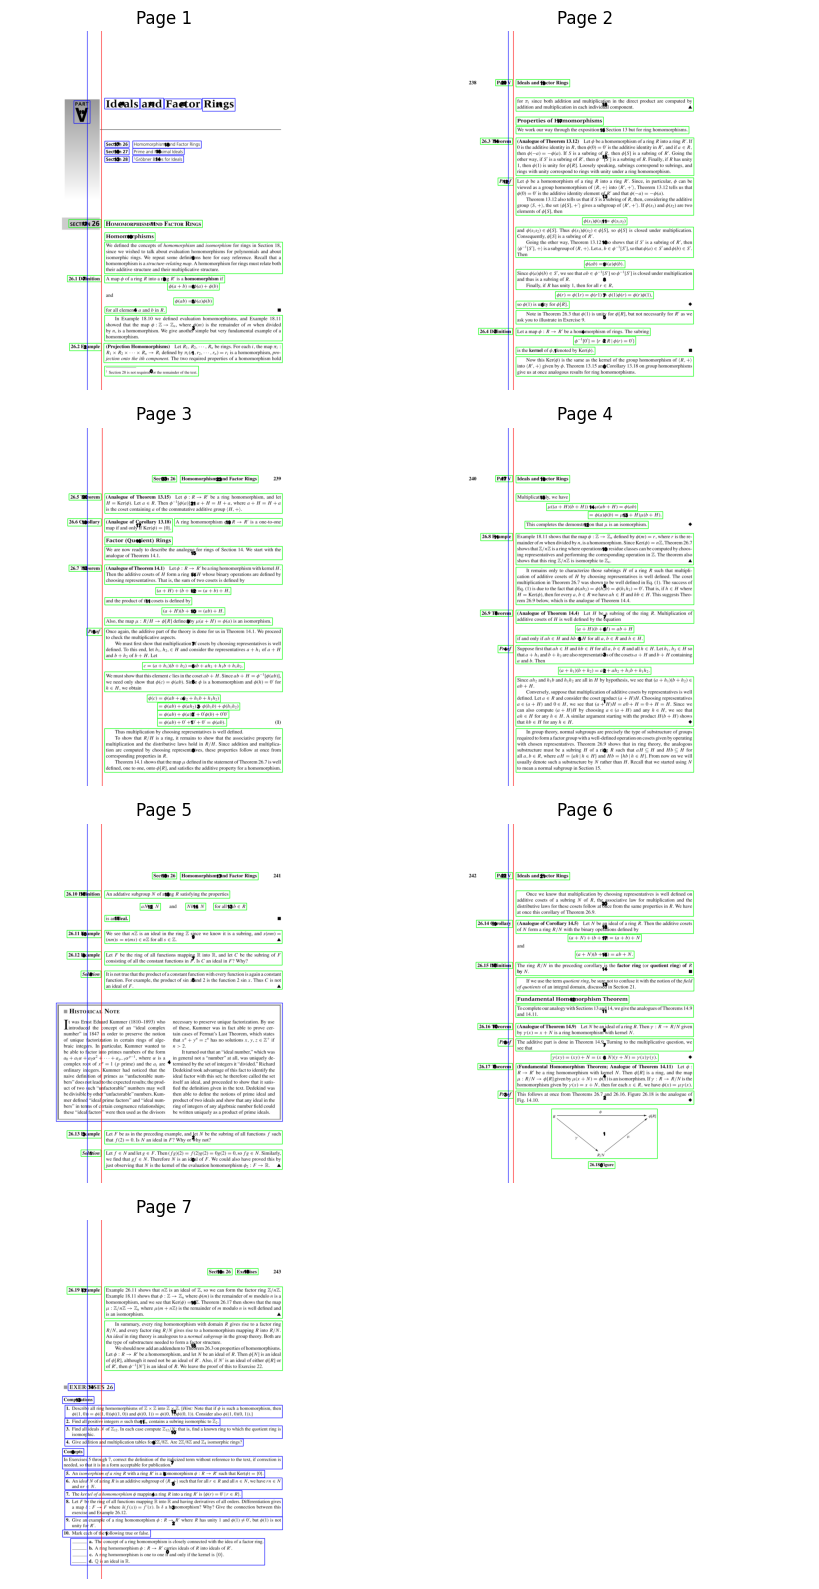

In [12]:
processed_images = [process_page(img, kernel_k=9) for img in images]

plot_pdf_pages_grid(processed_images, N=100, k=2, save_path='part5_ideals_boxes.png')

Image saved to part2_permutations_boxes.png


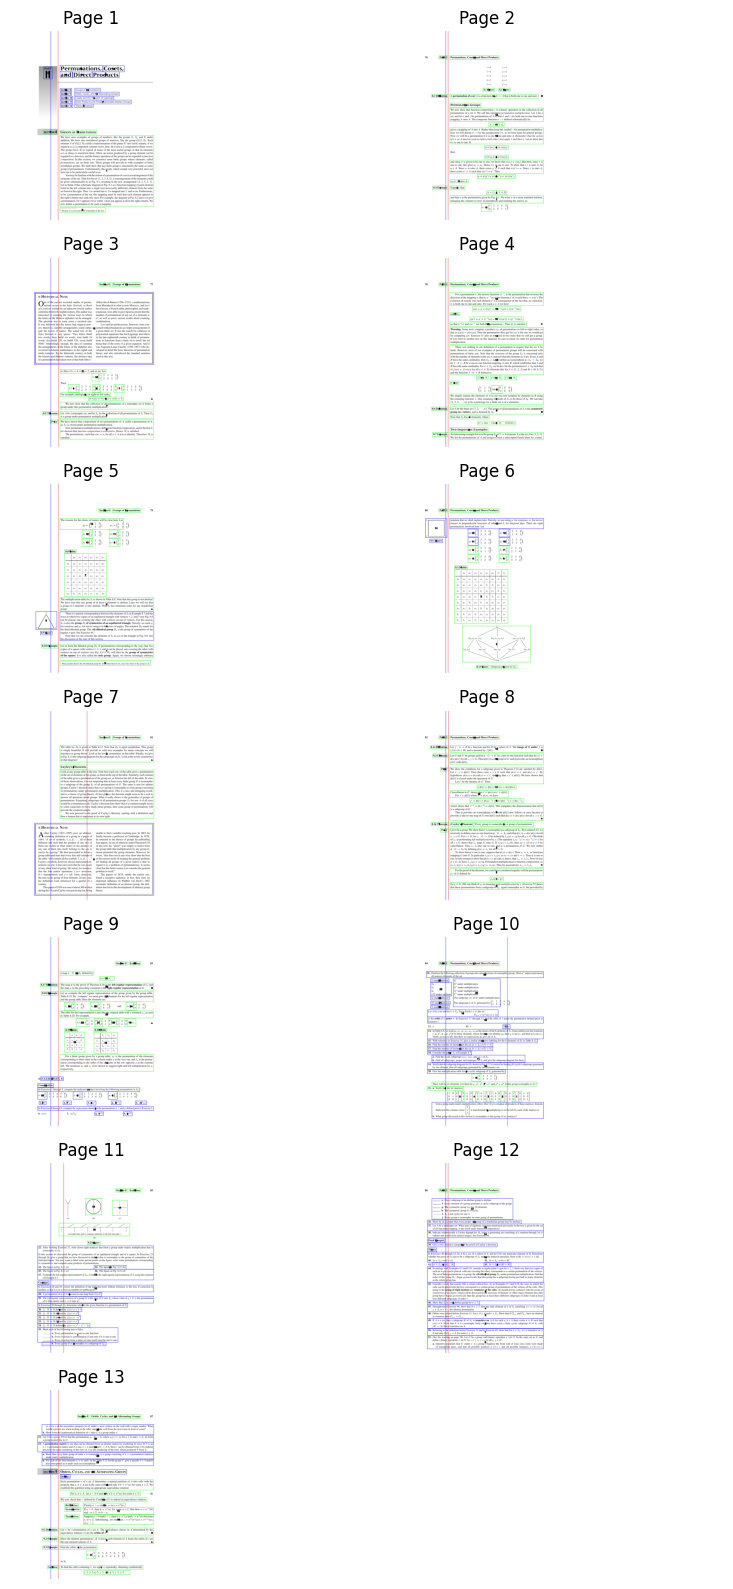

In [14]:
test_images = convert_from_path('src/algebra_graph/part2_permutations.pdf')
if not test_images:
    raise ValueError("No pages found in the PDF.")

processed_images = [process_page(img, kernel_k=9) for img in test_images]
plot_pdf_pages_grid(processed_images, N=100, k=2, save_path='part2_permutations_boxes.png')

In [20]:
def process_page_for_boxes(image, bottom_crop=0.10, min_width=75, kernel_k=3):
    image_arr = np.array(image)[:int((1 - bottom_crop) * image.height)]

    image_rgb = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((kernel_k, kernel_k), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    large_contours = find_large_contours(image)

    boxes = []
    all_contours = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > min_width and h > 20:
            all_contours.append((x, y, w, h))

            near_large_contour = False
            for (lc_y, lc_h) in large_contours:
                if (y < lc_y + lc_h) and (y + h > lc_y):
                    near_large_contour = True
                    break
            if not near_large_contour:
                boxes.append((x, y, w, h))

    optimal_x = find_optimal_vertical_line(boxes, large_contours)
    right_boxes, left_boxes = [], []

    for (x, y, w, h) in all_contours:
        excluded = False
        for (lc_y, lc_h) in large_contours:
            if (y < lc_y + lc_h) and (y + h > lc_y):
                excluded = True
                break
        
        if not excluded:
            if x + h <= optimal_x:
                cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 0, 255), 2)
                left_boxes.append((x, y, x + w, y + h))
            else:
                cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)
                right_boxes.append((x, y, x + w, y + h))

    if optimal_x is not None and optimal_x < image_rgb.shape[1] * 0.4:
        return left_boxes, right_boxes
    
    return [], []

Image saved to part5_ideals_boxes_filtered.png


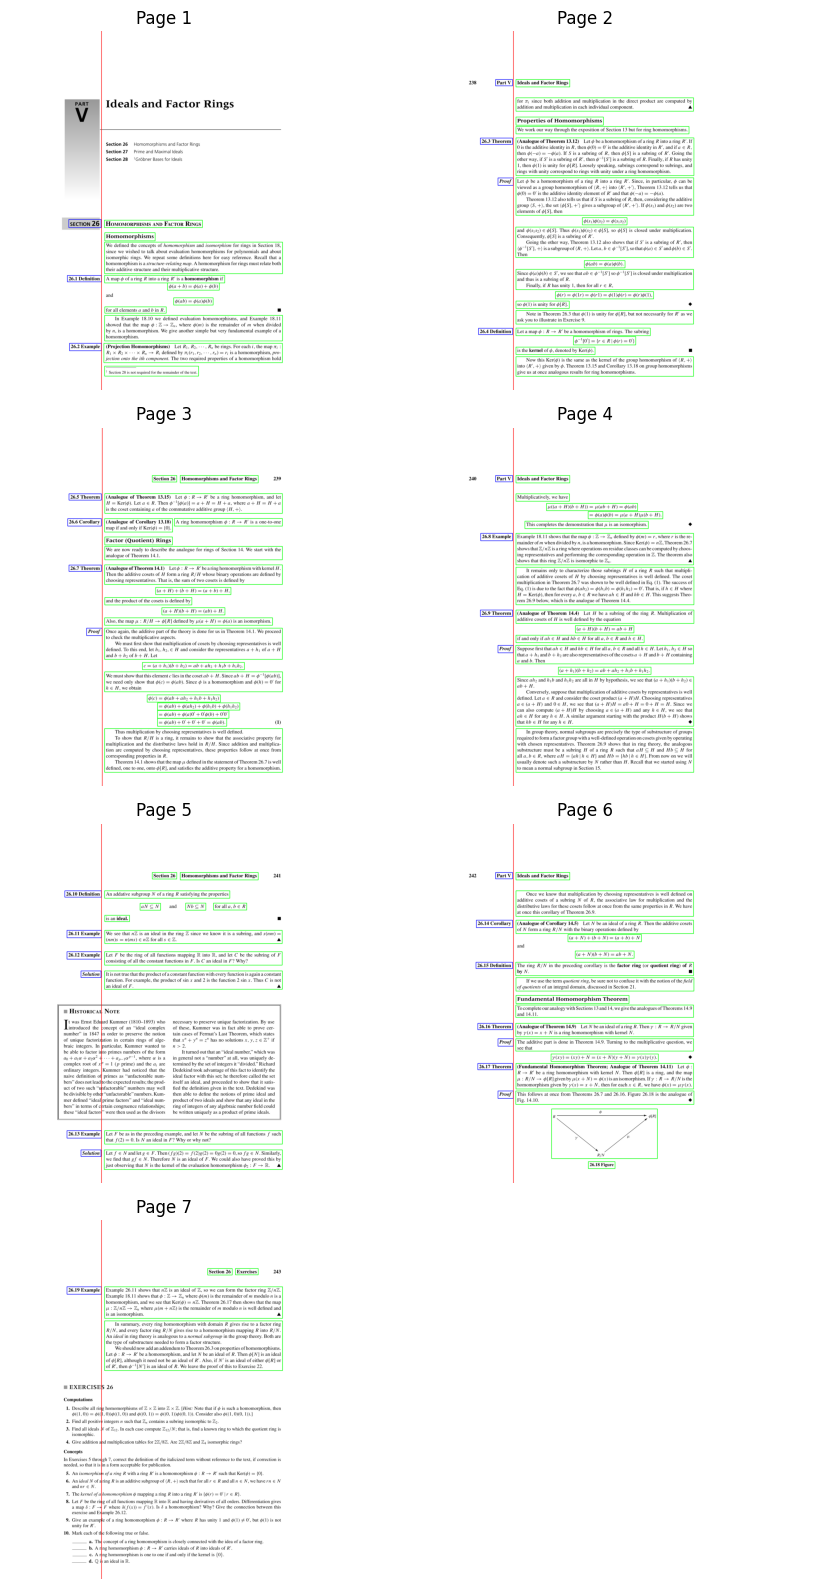

In [16]:
processed_images = [process_page_for_boxes(img, kernel_k=9) for img in images]
plot_pdf_pages_grid(processed_images, N=100, k=2, save_path='part5_ideals_boxes_filtered.png')

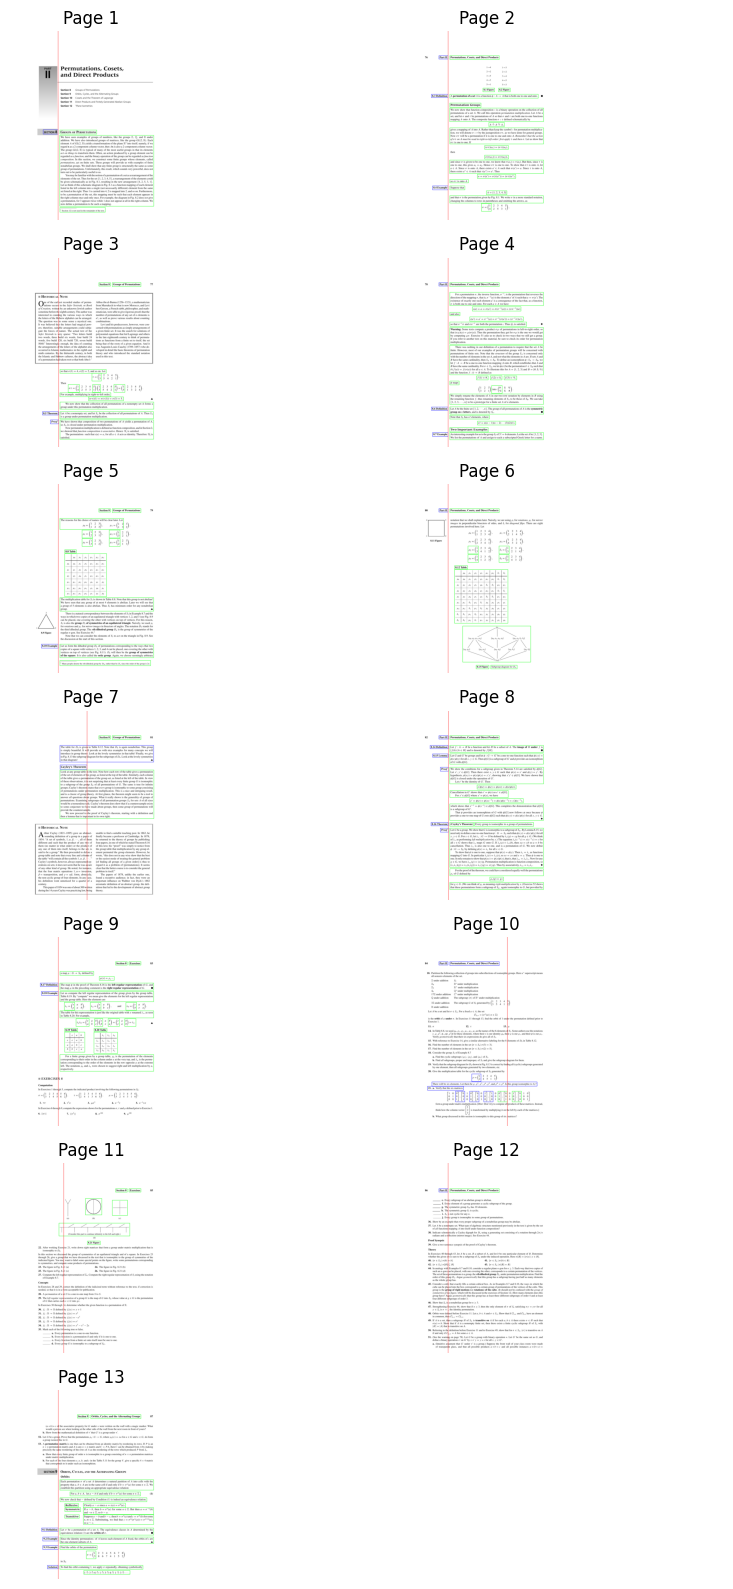

In [17]:
processed_images = [process_page_for_boxes(img, kernel_k=9) for img in test_images]
plot_pdf_pages_grid(processed_images, N=100, k=2, save_path=None)

In [ ]:
from collections import OrderedDict, defaultdict

class OrderedDefaultDict(OrderedDict):
    def __init__(self, default_factory=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_factory = default_factory

    def __missing__(self, key):
        if self.default_factory is None:
            raise KeyError(key)
        self[key] = value = self.default_factory()
        return value

    def append_to_last(self, value): # append to last value of type list
        if not self:
            raise IndexError("Cannot append to last: OrderedDefaultDict is empty.")
        last_key = next(reversed(self))
        self[last_key].append(value)

In [29]:
box_pairs = OrderedDefaultDict(list)
margin = 10

for img in images:
    key_boxes, value_boxes = process_page_for_boxes(img, kernel_k=9)
    key_boxes, value_boxes = key_boxes[::-1], value_boxes[::-1]

    key_y_tops = [key_box[1] for key_box in key_boxes]
    key_y_top_idx = 0

    for value_box in value_boxes:
        value_y_top = value_box[1]
        
        if key_y_top_idx < len(key_y_tops) and abs(value_y_top - key_y_tops[key_y_top_idx]) <= margin:
            box_pairs[key_boxes[key_y_top_idx]].append(value_box)
            key_y_top_idx += 1

        else:
            box_pairs.append_to_last(value_box)

In [30]:
dict(box_pairs)

{(323, 1039, 500, 1084): [(519, 1043, 1058, 1084),
  (521, 1112, 798, 1157),
  (520, 1164, 1499, 1338)],
 (315, 1348, 502, 1383): [(520, 1347, 1181, 1389),
  (866, 1389, 1151, 1429),
  (900, 1471, 1117, 1511),
  (521, 1521, 859, 1556),
  (520, 1568, 1499, 1709)],
 (327, 1722, 502, 1763): [(516, 1722, 1498, 1829), (520, 1848, 1037, 1903)],
 (355, 267, 448, 302): [(467, 267, 763, 308),
  (467, 368, 1444, 442),
  (467, 474, 948, 519),
  (467, 526, 1419, 567),
  (467, 267, 763, 308),
  (467, 267, 763, 308)],
 (271, 590, 448, 625): [(467, 589, 1446, 797)],
 (368, 810, 452, 851): [(467, 809, 1445, 1016),
  (832, 1029, 1078, 1069),
  (466, 1081, 1444, 1249),
  (843, 1266, 1067, 1306),
  (467, 1314, 1444, 1426),
  (684, 1437, 1224, 1477),
  (467, 1489, 760, 1530),
  (467, 1541, 1444, 1616)],
 (261, 1639, 448, 1674): [(467, 1638, 1206, 1680),
  (783, 1685, 1126, 1731),
  (467, 1743, 902, 1784),
  (467, 1796, 1444, 1904),
  (782, 267, 917, 303),
  (936, 267, 1365, 308)],
 (324, 368, 502, 403): [